In [1]:
from collections import Counter
import os
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import html, dash_table, dcc
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from threading import Thread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Set the environment variable to disable oneDNN custom operations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from plotly.subplots import make_subplots

## Exploratory Data Analysis

In [2]:
spotify_data = pd.read_csv('result_spotify_dataset.csv')
genre_data = pd.read_csv('train.csv')

In [3]:
spotify_data.head()

user_id   artistname        trackname  \
0  c1a6910ecac9fd5e5348326675fb6ca6  Jon Hopkins   Abandon Window   
1  c1a6910ecac9fd5e5348326675fb6ca6      Grouper         Clearing   
2  c1a6910ecac9fd5e5348326675fb6ca6   Com Truise           Closed   
3  c1a6910ecac9fd5e5348326675fb6ca6    Radiohead            Codex   
4  c1a6910ecac9fd5e5348326675fb6ca6  Nina Simone  Cotton Eyed Joe   

  playlistname                 song_id  danceability  energy  key  loudness  \
0        CHILL  5BKp7nLEzAtazOxYla2sBr         0.063  0.1730  6.0   -26.199   
1        CHILL  3IL43TRkEnh4buGOZ1Brb5         0.230  0.0432  6.0   -23.066   
2        CHILL  1z2iz13gYpqnH4IwUQsSLx         0.623  0.5200  2.0    -7.926   
3        CHILL  6ttYF5VadzTssGV2i1Q08T         0.346  0.1280  2.0   -17.536   
4        CHILL  3d5Mw0esNjnh123xyy48IF         0.421  0.0820  0.0   -18.893   

   mode  ...  instrumentalness  liveness  valence    tempo            type  \
0   1.0  ...          0.836000    0.0863   0.1120   68.963  audio_features   
1   1.0  ...          0.932000    0.1050   0.1360   89.582  audio_features   
2   1.0  ...          0.839000    0.0899   0.1720  172.051  audio_features   
3   0.0  ...          0.760000    0.1300   0.0654   58.996  audio_features   
4   1.0  ...          0.000209    0.1280   0.2040   72.529  audio_features   

   duration_ms time_signature  \
0     297493.0            3.0   
1     281680.0            4.0   
2     184000.0            4.0   
3     287067.0            4.0   
4     171280.0            4.0   

                                        analysis_url  \
0  https://api.spotify.com/v1/audio-analysis/5BKp...   
1  https://api.spotify.com/v1/audio-analysis/3IL4...   
2  https://api.spotify.com/v1/audio-analysis/1z2i...   
3  https://api.spotify.com/v1/audio-analysis/6ttY...   
4  https://api.spotify.com/v1/audio-analysis/3d5M...   

                                    uri                      id  
0  spotify:track:5BKp7nLEzAtazOxYla2sBr  5BKp7nLEzAtazOxYla2sBr  
1  spotify:track:3IL43TRkEnh4buGOZ1Brb5  3IL43TRkEnh4buGOZ1Brb5  
2  spotify:track:1z2iz13gYpqnH4IwUQsSLx  1z2iz13gYpqnH4IwUQsSLx  
3  spotify:track:6ttYF5VadzTssGV2i1Q08T  6ttYF5VadzTssGV2i1Q08T  
4  spotify:track:3d5Mw0esNjnh123xyy48IF  3d5Mw0esNjnh123xyy48IF  

[5 rows x 22 columns]

In [4]:
genre_data.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

In [5]:
print('\x1b[1;31m'+'Total Records in Spotify Dataset :'+'\x1b[0m', len(spotify_data))
print('\x1b[1;31m'+'Duplicate Records in Spotify Dataset :'+'\x1b[0m', len(spotify_data[spotify_data.duplicated()]))

Total Records in Spotify Dataset : 28469
Duplicate Records in Spotify Dataset : 0


In [6]:
print('\x1b[1;31m'+'Total Records in Genre Dataset :'+'\x1b[0m', len(genre_data))
print('\x1b[1;31m'+'Duplicate Records in Genre Dataset :'+'\x1b[0m', len(genre_data[genre_data.duplicated()]))
genre_data = genre_data.drop_duplicates()
print('\x1b[1;31m'+'Total Records after dropping duplicates :'+'\x1b[0m', len(genre_data))

Total Records in Genre Dataset : 17996
Duplicate Records in Genre Dataset : 0
Total Records after dropping duplicates : 17996


In [7]:
spotify_data.describe()

danceability        energy           key      loudness          mode  \
count  28469.000000  28469.000000  28469.000000  28469.000000  28469.000000   
mean       0.546875      0.641947      5.186132     -8.442115      0.655836   
std        0.172200      0.247924      3.570595      4.843543      0.475103   
min        0.000000      0.000000      0.000000    -60.000000      0.000000   
25%        0.432000      0.481000      2.000000    -10.119000      0.000000   
50%        0.554000      0.693000      5.000000     -7.226000      1.000000   
75%        0.671000      0.845000      8.000000     -5.293000      1.000000   
max        0.988000      0.999000     11.000000      2.017000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  28469.000000  28469.000000      28469.000000  28469.000000   
mean       0.076269      0.266104          0.150150      0.202869   
std        0.098086      0.320394          0.294507      0.180680   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.033900      0.010300          0.000000      0.095600   
50%        0.044100      0.101000          0.000271      0.127000   
75%        0.071900      0.464000          0.075700      0.258000   
max        0.961000      0.996000          1.000000      0.999000   

            valence        tempo   duration_ms  time_signature  
count  28469.000000  28469.00000  2.846900e+04     28469.00000  
mean       0.480868    121.76861  2.438535e+05         3.89824  
std        0.254482     28.67606  9.741088e+04         0.43739  
min        0.000000      0.00000  3.329000e+03         0.00000  
25%        0.275000    100.42200  1.960000e+05         4.00000  
50%        0.473000    120.85000  2.317730e+05         4.00000  
75%        0.684000    138.70400  2.737330e+05         4.00000  
max        0.993000    238.89500  4.057195e+06         5.00000

In [8]:
genre_data.describe()

Popularity  danceability        energy           key      loudness  \
count  17568.000000  17996.000000  17996.000000  15982.000000  17996.000000   
mean      44.512124      0.543433      0.662777      5.952447     -7.910660   
std       17.426928      0.166268      0.235373      3.196854      4.049151   
min        1.000000      0.059600      0.000020      1.000000    -39.952000   
25%       33.000000      0.432000      0.509000      3.000000     -9.538000   
50%       44.000000      0.545000      0.700000      6.000000     -7.016000   
75%       56.000000      0.659000      0.860000      9.000000     -5.189000   
max      100.000000      0.989000      1.000000     11.000000      1.355000   

               mode   speechiness  acousticness  instrumentalness  \
count  17996.000000  17996.000000  17996.000000      13619.000000   
mean       0.636753      0.079707      0.247082          0.177562   
std        0.480949      0.083576      0.310632          0.304048   
min        0.000000      0.022500      0.000000          0.000001   
25%        0.000000      0.034800      0.004300          0.000089   
50%        1.000000      0.047400      0.081400          0.003910   
75%        1.000000      0.083000      0.434000          0.200000   
max        1.000000      0.955000      0.996000          0.996000   

           liveness       valence         tempo  duration_in min/ms  \
count  17996.000000  17996.000000  17996.000000        1.799600e+04   
mean       0.196170      0.486208    122.623294        2.007445e+05   
std        0.159212      0.240195     29.571527        1.119891e+05   
min        0.011900      0.018300     30.557000        5.016500e-01   
25%        0.097500      0.297000     99.620750        1.663370e+05   
50%        0.129000      0.481000    120.065500        2.091600e+05   
75%        0.258000      0.672000    141.969250        2.524900e+05   
max        1.000000      0.986000    217.416000        1.477187e+06   

       time_signature         Class  
count    17996.000000  17996.000000  
mean         3.924039      6.695821  
std          0.361618      3.206073  
min          1.000000      0.000000  
25%          4.000000      5.000000  
50%          4.000000      8.000000  
75%          4.000000     10.000000  
max          5.000000     10.000000

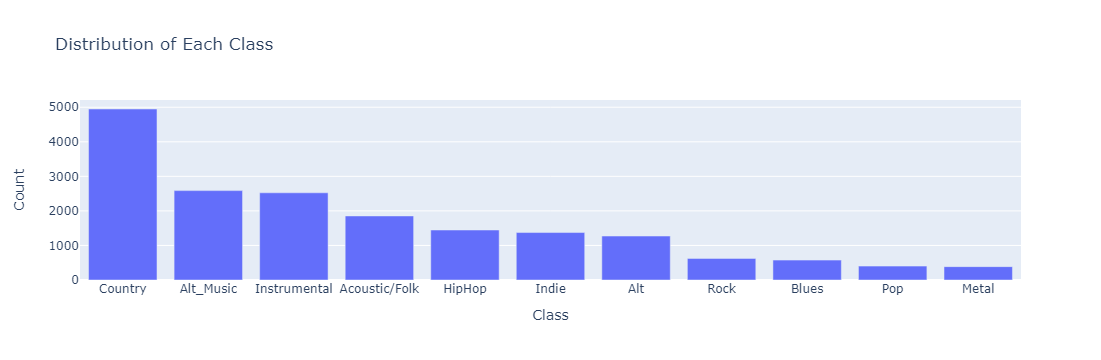

In [9]:
labels = ["Rock", "Indie", "Alt", "Pop", "Metal", "HipHop", "Alt_Music", "Blues", "Acoustic/Folk", "Instrumental", "Country"]
 
class_distribution = genre_data['Class'].value_counts().sort_values(ascending=False)
 
# Create a dictionary to map class numbers to labels
label_dict = {i: label for i, label in enumerate(labels)}
 
# Replace class numbers with labels
class_distribution.index = class_distribution.index.map(label_dict)
 
fig = px.bar(class_distribution, x=class_distribution.index, y=class_distribution.values, labels={'x':'Class', 'y':'Count'}, title='Distribution of Each Class')
fig.show()

In [10]:
def mapper(col):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in spotify_data[col]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1
        
        encoded.append(coded_dict[val])
    return encoded

In [11]:
def normalize(numerical_columns, df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df.loc[:, numerical_columns] = min_max_scaler.fit_transform(df[numerical_columns])
    return df

In [12]:
artist_id = mapper('artistname')
user_ids = mapper('user_id')

In [13]:
# Handle spotify dataset (Preprocessing) 
spotify_data['artistname_encoded'] = artist_id
spotify_data['user_id_encoded'] = user_ids
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

In [14]:
# Handle genre dataset (Preprocessing)
genre_data.dropna(inplace=True)
genre_data.drop(['Popularity', 'time_signature', 'duration_in min/ms'], axis='columns', inplace=True)
genre_data.rename(columns={'Artist Name': 'artistname', 'Track Name': 'trackname'}, inplace=True)
# Normalize numerical columns
columns = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
            "liveness", "valence", "tempo"]
genre_data = normalize(columns, genre_data)

In [15]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP], suppress_callback_exceptions=True)

In [16]:
genre_identification_model = None
genre_identification_preprocessor = None

## Tempo & Valence Analysis

In [17]:
@app.callback(
    Output("tempo-valence-figure", "figure"),
    [
        Input("user-tempo-valence-analysis-dropdown", "value"),
        Input('user-tempo-valence-analysis-playlist-dropdown', 'value')
    ]
)
def tempo_valence_figure(user_id, playlist_name):
    numerical_columns = ['valence', 'tempo']
    df = spotify_data[(spotify_data['playlistname'] == playlist_name) & (spotify_data['user_id']==user_id)]
    df = normalize(numerical_columns, df)
    df = df[numerical_columns]
    try:
        # Create scatter plot
        fig = px.scatter(df, x="valence", y="tempo", color="valence")
    except ValueError:
        fig = px.scatter(df, x="valence", y="tempo", color="valence")
    return fig

In [18]:
@app.callback(
    [
        Output('user-tempo-valence-analysis-playlist-dropdown', 'options'),
        Output('user-tempo-valence-analysis-playlist-dropdown', 'value')
    ],
    [
        Input('user-tempo-valence-analysis-dropdown', 'value'),
    ]
)
def update_tempo_valence_dropdown(user_id):
    df = spotify_data[spotify_data['user_id'] == user_id]
    options = [{'label': playlist, 'value': playlist} for playlist in df['playlistname'].unique()]
    return options, options[0]['value']

## Song Duration Analysis

In [19]:
@app.callback(
    Output("song-duration-figure", "figure"),
    [
        Input("user-song-duration-dropdown", "value"),
        Input('user-song-duration-playlist-dropdown', 'value')
    ]
)
def song_duration_figure(user_id, playlist_name):
    df = spotify_data[(spotify_data['playlistname'] == playlist_name) & (spotify_data['user_id'] == user_id)]

    # Convert duration_ms to minutes
    df['duration_minutes'] = df['duration_ms'] / (1000 * 60)
    # Calculate average duration
    avg_duration = df['duration_minutes'].mean()
    sorted_df = df.sort_values(by='duration_minutes', ascending=False)
    sorted_df['trackname'] = sorted_df['trackname'].apply(lambda x: x[:25] if len(x) > 25 else x)
    try:
        fig = px.histogram(sorted_df, x='trackname', y='duration_minutes')
    except ValueError:
        fig = px.histogram(sorted_df, x='trackname', y='duration_minutes')

    fig.add_shape(
        type='line',
        x0=0,
        x1=len(df['trackname']) - 1,
        y0=avg_duration,
        y1=avg_duration,
        line=dict(color='red', width=2, dash='dash')
    )

    fig.update_layout(
        xaxis=dict(title='Song Name'),
        yaxis=dict(title='Duration (minutes)'),
        showlegend=False
    )
    return fig

In [20]:
@app.callback(
    [
        Output('user-song-duration-playlist-dropdown', 'options'),
        Output('user-song-duration-playlist-dropdown', 'value')
    ],
    [
        Input('user-song-duration-dropdown', 'value'),
    ]
)
def update_song_duration_dropdown(user_id):
    df = spotify_data[spotify_data['user_id'] == user_id]
    options = [{'label': playlist, 'value': playlist} for playlist in df['playlistname'].unique()]
    return options, options[0]['value']   

## Feature Distribution Plots

In [21]:
@app.callback(
    Output("feature-distribution-figure", "figure"),
    [
        Input("graph-toggle", "value"),
        Input("feature-distribution-radio", "value")
    ]
)
def feature_distribution_figure(graph_type, feature):
    if graph_type == 'Violin':
        fig = px.violin(spotify_data, y=feature.lower())
    else:
        fig = px.histogram(spotify_data, x=feature.lower(), nbins=20)
    return fig

## Feature Correlation Heatmap

In [22]:
@app.callback(
    Output("feature-correlation-heatmap-figure", "figure"),
    [
        Input("feature-correlation-heatmap-figure", "id")   
    ],
)
def create_heatmap(_):
    numerical_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
    correlation = spotify_data[numerical_columns].corr()
    heatmap = px.imshow(correlation, color_continuous_scale='sunset', aspect="auto")
    heatmap.update_traces(text=np.around(correlation.values, decimals=2), texttemplate="%{text}")
    heatmap.update_xaxes(side="top")
    return heatmap

## User Song Preferences Analysis

In [23]:
@app.callback(
    Output("user-song-preference-analysis-figure", "figure"),
    [
        Input("user-song-preference-analysis-dropdown", "value"),
        Input('user-song-preference-analysis-radio', 'value'),
        Input("user-song-preference-analysis-playlist-dropdown", "value")
    ]
)
def create_radar_chart(user_id, radio_value, playlist_name=None):
    numerical_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

    if radio_value == 'Average':
        df = spotify_data[spotify_data['user_id']==user_id]
        df = normalize(numerical_columns, df)
        df = df[numerical_columns]
        average_features = df.mean().tolist()
        fig = px.line_polar(r=average_features, theta=numerical_columns, line_close=True)
    elif radio_value == 'Each song':
        df = spotify_data[spotify_data['user_id']==user_id]
        df = normalize(numerical_columns, df)
        df = df.reset_index().melt(id_vars='trackname', value_vars=numerical_columns)
        fig = px.line_polar(df, r='value', theta='variable', color='trackname', line_close=True)
    elif radio_value in ['Each playlist', 'Average in a playlist', 'Each song in a playlist']:
        if radio_value == 'Each playlist':
            df = spotify_data[spotify_data['user_id']==user_id]
            df = normalize(numerical_columns, df)
            df = df.groupby('playlistname')[numerical_columns].mean().reset_index()
            df = df.reset_index().melt(id_vars='playlistname', value_vars=numerical_columns)
            fig = px.line_polar(df, r='value', theta='variable', color='playlistname', line_close=True)
        elif radio_value == 'Average in a playlist':
            df = spotify_data[(spotify_data['playlistname'] == playlist_name) & (spotify_data['user_id']==user_id)]
            df = normalize(numerical_columns, df)
            df = df[numerical_columns]
            average_features = df.mean().tolist()
            fig = px.line_polar(r=average_features, theta=numerical_columns, line_close=True)
        elif radio_value == 'Each song in a playlist':
            df = spotify_data[(spotify_data['playlistname'] == playlist_name) & (spotify_data['user_id']==user_id)]
            df = normalize(numerical_columns, df)
            df = df.reset_index().melt(id_vars='trackname', value_vars=numerical_columns)
            fig = px.line_polar(df, r='value', theta='variable', color='trackname', line_close=True)

    fig.update_traces(fill='toself')
    return fig

In [24]:
@app.callback(
    [
        Output('user-song-preference-analysis-playlist-dropdown', 'options'),
        Output('user-song-preference-analysis-playlist-dropdown', 'value')
    ],
    [
        Input('user-song-preference-analysis-dropdown', 'value'), 
        Input('user-song-preference-analysis-radio', 'value')
    ]
)
def update_dropdown_song_preference(user_id, radio_value):
    if radio_value in ['Average in a playlist', 'Each song in a playlist']:
        df = spotify_data[spotify_data['user_id'] == user_id]
        options = [{'label': playlist, 'value': playlist} for playlist in df['playlistname'].unique()]
        return options, options[0]['value'] 
    else:
        return [{'label':'default', 'value':'default', 'disabled':True}], 'default'

## Similar User Matching

In [25]:
def create_user_artist_matrix(spotify_data):
    spotify_data['interact'] = 1
    user_artist = spotify_data.groupby(['user_id_encoded', 'artistname_encoded'])['interact'].max().unstack().fillna(0).astype('int')
    return user_artist

def generate_recommendations_collaborative(user_id, user_artist, threshold):
    user_id_encoded = spotify_data[spotify_data['user_id']==user_id]['user_id_encoded'].values[0]
    # compute similarity of each user to the provided user
    similarity_users = np.dot(user_artist.loc[user_id_encoded], user_artist.transpose())
    similarity_users = pd.DataFrame(similarity_users, columns=['similarity'])
    
    # create similar_user_id column
    # Adding 1 because index starts from 0 in pandas
    similarity_users['similar_user_id'] = similarity_users.index + 1
    
    # Find common artists to apply threshold
    common_artists = find_common_artists(user_id, user_artist)
    
    # Apply threshold
    similarity_users = similarity_users[similarity_users['similar_user_id'].isin([user for user, count in common_artists.items() if count >= threshold])]
 
    # calculate the percentage of similarity
    similarity_users['similarity_percentage'] = similarity_users['similar_user_id'].apply(lambda x: jaccard_similarity(user_id_encoded, x, user_artist))
    
    # remove the own user's id
    similarity_users = similarity_users[similarity_users['similar_user_id'] != user_id_encoded]
    
    # sort by similarity and then by percentage similarity
    similarity_users.sort_values(by=['similarity', 'similarity_percentage'], ascending=False, inplace=True)
    
    # Remove recommendations that have no similarity
    similarity_users = similarity_users[similarity_users['similarity_percentage'] > 0]
    
    # Get the list of similar user ids for evaluating the algorithm
    recommendations = similarity_users['similar_user_id'].tolist()
    
    precision, recall, f1_score = calculate_metrics(recommendations, common_artists, threshold=5)
    
    similarity_users = similarity_users.assign(similar_user_id=similarity_users['similar_user_id'].apply(lambda x: spotify_data.loc[spotify_data['user_id_encoded'] == x, 'user_id'].values[0] if x in spotify_data['user_id_encoded'].values else x))
    col = similarity_users.pop('similar_user_id')
    similarity_users.insert(0, col.name, col)
    
    return similarity_users, precision, recall, f1_score

def jaccard_similarity(user1, user2, user_artist):
    # Get the artists for each user
    artists_user1 = set(user_artist.loc[user1].to_numpy().nonzero()[0])
    artists_user2 = set(user_artist.loc[user2].to_numpy().nonzero()[0])
    
    
    # Calculate the intersection and union of the artists
    intersection = len(artists_user1.intersection(artists_user2))
    union = len(artists_user1.union(artists_user2))
    
    # Calculate Jaccard Similarity
    similarity = intersection / union if union != 0 else 0
    
    return similarity * 100

def find_common_artists(user_id, user_artist):
    user_id_encoded = spotify_data[spotify_data['user_id']==user_id]['user_id_encoded'].values[0]
    # Find the artists that the target user has interacted with
    target_artists = set(user_artist.loc[user_id_encoded][user_artist.loc[user_id_encoded]==1].index)

    # Create a dictionary to store each user and their count of common artists with the target user
    common_artists = {}

    # Iterate over each user
    for user in user_artist.index:
        if user != user_id:  # Exclude the target user
            # Find the artists that the current user has interacted with
            user_artists = set(user_artist.loc[user][user_artist.loc[user]==1].index)
            
            # Find the common artists between the target user and the current user
            common = target_artists & user_artists
            
            # Store the count of common artists in the dictionary
            common_artists[user] = len(common)

    return common_artists

def calculate_metrics(recommendations, common_artists, threshold):
    # Calculate the number of recommended users
    num_recommended = len(recommendations)

    # Calculate the number of relevant users (i.e., users who have more than 'threshold' artists in common with the target user)
    num_relevant = sum(1 for user, count in common_artists.items() if count >= threshold)

    # Calculate the number of true positives (i.e., relevant users who were also recommended)
    num_true_positives = sum(1 for user in recommendations if common_artists[user] >= threshold)

    # Precision is the proportion of recommended users that are relevant
    precision = num_true_positives / num_recommended if num_recommended else 0

    # Recall is the proportion of relevant users that are recommended
    recall = num_true_positives / num_relevant if num_relevant else 0

    # F1 score is the harmonic mean of precision and recall
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score

def calculate_threshold(user_id):
    user_id_encoded = spotify_data[spotify_data['user_id']==user_id]['user_id_encoded'].values[0]
    user_artist = create_user_artist_matrix(spotify_data)
    threshold = 0
    user_artist_count = len(user_artist.loc[user_id_encoded][user_artist.loc[user_id_encoded]==1])
    for i in range(0, user_artist_count+1):
        user_recommendations, precision, recall, f1_score = generate_recommendations_collaborative(user_id, user_artist, threshold=threshold)
        if len(user_recommendations) == 0:
            return threshold
        threshold+=1

# Callback to update the graph based on the selected threshold
def metrics_thresholds_graph_collaborative(user_id, user_artist):
    collaborative_precision_list = []
    collaborative_recall_list = []
    collaborative_f1_score_list = []

    for t in range(0, 11):
        user_recommendations, collaborative_precision, collaborative_recall, collaborative_f1_score = generate_recommendations_collaborative(user_id=user_id, user_artist=user_artist, threshold=t)
        collaborative_precision_list.append(collaborative_precision)
        collaborative_recall_list.append(collaborative_recall)
        collaborative_f1_score_list.append(collaborative_f1_score)

    thresholds = list(range(0, 11, 1))

    df = pd.DataFrame({
        'Threshold': thresholds,
        'Precision': collaborative_precision_list,
        'Recall': collaborative_recall_list,
        'F1 Score': collaborative_f1_score_list
    })

    # Plot with Plotly Express
    fig = px.line(df, x='Threshold', y=['Precision', 'Recall', 'F1 Score'], markers=True, title='Evaluation Metrics at Different Thresholds')
    fig.update_xaxes(title='Threshold')
    fig.update_yaxes(title='Score')
    fig.update_layout(legend=dict(title='Metrics'))
    
    return fig

In [26]:
@app.callback(
    [
        Output('similar-user-matching-content-based-slider-div', 'children'),
        Output('similar-user-matching-content-based-slider-div', 'style')
    ],
    [
        Input('similar-user-matching-dropdown', 'value'),
        Input('similar-user-matching-radio', 'value')
    ]
)
def update_dropdown_content_based(user_id, radio_value):
    user_features = spotify_data[spotify_data['user_id_encoded'] == 100].mean(numeric_only=True)[:-3].to_dict()
    div = html.Div(children=[])    
    div.children.append(html.Div([
        html.H4(children="Adjust threshold (Number of features with values equal or more than your values.)"),
        dcc.Slider(id="similar-user-matching-content-based-slider", min=0, max=13, step=1, value=4)
    ]))
    if radio_value == "Your specific music taste":
        return div, {'display': 'block', 'margin-top': '20px', 'margin-bottom' : '20px'}
    else:
        return div, {'display': 'none'}

In [27]:
@app.callback(
    Output('similar-user-matching-collaborative-slider', 'max'),
    Input('similar-user-matching-dropdown', 'value')
)
def update_slider_max(selected_user):
    max_threshold = calculate_threshold(selected_user)
    return max_threshold

@app.callback(
    Output('similar-user-matching-collaborative-slider-div', 'style'),
    Input('similar-user-matching-radio', 'value')
)
def update_slider_visibility(selected_value):
    if selected_value == 'Artists you have in common':
        return {'display': 'block', 'margin-top': '20px', 'margin-bottom' : '20px'}
    else:
        return {'display': 'none'}

def generate_recommendations_content_based(user_id, spotify_data, threshold):
    user_id_encoded = spotify_data[spotify_data['user_id']==user_id]['user_id_encoded'].values[0]
    # Get user feature values
    feature_values_dict = spotify_data[spotify_data['user_id_encoded'] == user_id_encoded].mean(numeric_only=True)[:-3].to_dict()
    
    # Aggregate spotify_data by user
    data_agg = spotify_data[feature_values_dict.keys()].groupby(spotify_data['user_id_encoded']).mean()
    
    # print(data_agg, feature_values_dict)
    
    # Adjust the feature values of the target user
    data_agg.loc[user_id_encoded] = list(feature_values_dict.values())
    
    # Calculate the cosine similarity between the user and all other users
    similarity_scores = cosine_similarity(data_agg.loc[user_id_encoded].values.reshape(1, -1), data_agg.values)[0]
    
    # Create a DataFrame for the similarity scores
    similarity_df = pd.DataFrame(similarity_scores, columns=['similarity'], index=data_agg.index)
    
    similarity_df.reset_index(inplace=True)
    # Remove the user's own id
    similarity_df = similarity_df[similarity_df['user_id_encoded'] != user_id_encoded]
    # Sort the users by similarity score
    similarity_df.sort_values(by='similarity', ascending=False, inplace=True)
    # Calculate percentages of similarity
    similarity_df['similarity_percentage'] = similarity_df['similarity'] * 100
    recommended_users = similarity_df['user_id_encoded'].tolist()
    precision, recall, f1_score = calculate_metrics_content_based(recommended_users, spotify_data, feature_values_dict, threshold)
    return similarity_df, precision, recall, f1_score


def calculate_metrics_content_based(recommended_users, data, user_features, threshold):
    tp = 0
    fp = 0
    fn = 0
    relevant_users = set(data[data['user_id_encoded'].isin(recommended_users)]['user_id_encoded'])

    for user in recommended_users:
        # Calculate the aggregate of their song features
        similar_user_features = data[data['user_id_encoded'] == user].mean(numeric_only=True)[:-3].to_dict()

        # Compare that to the user_features
        num_similar_features_above_threshold = sum(similar_user_features[feature] >= user_features[feature] for feature in user_features)

        is_relevant = num_similar_features_above_threshold >= threshold

        if is_relevant:
            tp += 1
        else:
            # If user is recommended but not relevant
            if user in relevant_users:
                fp += 1
            else:
                fn += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def metrics_thresholds_graph_content_based(user_id):
    content_based_precision_list = []
    content_based_recall_list = []
    content_based_f1_score_list = []

    for t in np.arange(1, 13, 1):
        cosine_sim_df, content_based_precision, content_based_recall, content_based_f1_score = generate_recommendations_content_based(user_id, spotify_data, t)
        content_based_precision_list.append(content_based_precision)
        content_based_recall_list.append(content_based_recall)
        content_based_f1_score_list.append(content_based_f1_score)

    thresholds = list(np.arange(1, 13, 1))

    df = pd.DataFrame({
        'Threshold': thresholds,
        'Precision': content_based_precision_list,
        'Recall': content_based_recall_list,
        'F1 Score': content_based_f1_score_list
    })

    # Plot with Plotly Express
    fig = px.line(df, x='Threshold', y=['Precision', 'Recall', 'F1 Score'], markers=True, title='2. Evaluation Metrics at Different Thresholds')
    fig.update_xaxes(title='Threshold')
    fig.update_yaxes(title='Score')
    fig.update_layout(legend=dict(title='Metrics'))

    return fig

In [28]:
@app.callback(
    [
        Output("similar-user-matching-figure1", "figure"),
        Output("similar-user-matching-figure2", "figure"),
        Output("similar-user-matching-table", "children")
    ], 
    [
        Input("similar-user-matching-dropdown", "value"),
        Input("similar-user-matching-radio", "value"),
        Input("similar-user-matching-collaborative-slider","value"),
        Input("similar-user-matching-content-based-slider","value"),
    ]
)
def similar_user_matching(user_id, radio_value, collaborative_threshold, content_based_threshold):
    if radio_value == "Artists you have in common":
        user_artist = create_user_artist_matrix(spotify_data)
        similarity_df, precision, recall, f1_score = generate_recommendations_collaborative(user_id, user_artist, collaborative_threshold)
        fig2 = metrics_thresholds_graph_collaborative(user_id, user_artist)
    elif radio_value == "Your specific music taste":
        similarity_df, precision, recall, f1_score = generate_recommendations_content_based(user_id, spotify_data, content_based_threshold)
        fig2 = metrics_thresholds_graph_content_based(user_id)
    else: return None, None, None

    df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Score': [precision, recall, f1_score]
    })
    # Create the plot
    fig1 = px.bar(df, x='Metric', y='Score', title='1. Evaluation Metrics')
    
    # Create the table
    table = dash_table.DataTable(
        data=similarity_df.to_dict('records'),
        columns=[{'name': i, 'id': i} for i in similarity_df.columns],
        page_action='native',
        page_current=0,
        page_size=5,
        # Center the table on the page
        style_table={'margin-left': 'auto', 'margin-right': 'auto'}
        
    )
    return fig1, fig2, table

## Song Clustering & Exploration

In [29]:
@app.callback(
    Output('song-clustering-figure', 'figure'),
    Input('song-clustering-features-dropdown', 'value'),
    Input('song-clustering-slider', 'value')
)
def song_clustering_exploration(features, clusters):
    if not features or len(features) < 2:
        return dash.no_update
    
    X = spotify_data[features]
    # Normalize the values of each column
    X = (X - X.mean()) / X.std()

    # Initialize the KMeans model with 8 clusters
    kmeans = KMeans(n_clusters=clusters, random_state=1, n_init=10)

    # Fit the model to the spotify_data
    kmeans.fit(X) 
    clusters = kmeans.predict(X)

    pca = PCA(n_components=2)  # Initialize a PCA model with 2 components
    df_2d = pca.fit_transform(X)  # Reduce the spotify_data to two dimensions using the PCA model

    # Plot the spotify_data points on a scatter plot
    # Coloring the spotify_data points according to their cluster assignment
    fig = px.scatter(
        spotify_data,
        x=df_2d[:, 0],
        y=df_2d[:, 1],
        color=clusters,
        hover_data={'trackname': True},
        title='Clustering on Audio Features'
    )
    fig.update_layout(
        width=800,  # Set width in pixels
        height=600,
        xaxis_title='X-axis', 
        yaxis_title='Y-axis'
    )

    return fig

## Genre Identification

In [30]:
@app.callback(
    Output('genre-identification-figure1', 'figure'),
    Output('genre-identification-figure2', 'figure'),
    Input('genre-identification-learning-rate-slider', 'value')
)
def train_and_evaluate_model(alpha):
    global genre_identification_model
    global genre_identification_preprocessor
    # Split genre_data into features (X) and target labels (y)
    X, y = genre_data.drop('Class', axis=1), genre_data['Class']

    # Split genre_data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # One-hot encode categorical columns
    categorical_cols = ['artistname', 'trackname']
    genre_identification_preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])
    X_train = genre_identification_preprocessor.fit_transform(X_train)
    X_test = genre_identification_preprocessor.transform(X_test)

    # Encode target labels
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train.todense(), y_train_encoded))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test.todense(), y_test_encoded))
    train_dataset = train_dataset.shuffle(X_train.shape[0]).batch(32)
    test_dataset = test_dataset.batch(32)

    # Build and compile the model
    input_shape = X_train.shape[1]
    genre_identification_model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.7),
        Dense(11, activation='softmax')
    ])
    genre_identification_model.compile(optimizer=Adam(learning_rate=alpha), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = genre_identification_model.fit(train_dataset, epochs=10, batch_size=32, validation_data=test_dataset)

    # Evaluate the model on test data
    test_loss, test_accuracy = genre_identification_model.evaluate(test_dataset)
    print(f"Test accuracy: {test_accuracy}")

    # Plot loss and accuracy curves using Plotly Express
    evaluation_fig1 = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy Curve', 'Loss Curve'))

    evaluation_fig1.add_trace(go.Scatter(x=list(range(1, 11)), y=history.history['accuracy'], mode='lines', name='accuracy'),
                  row=1, col=1)
    evaluation_fig1.add_trace(go.Scatter(x=list(range(1, 11)), y=history.history['val_accuracy'], mode='lines', name='val_accuracy'),
                  row=1, col=1)
    evaluation_fig1.update_xaxes(title_text='Epoch', row=1, col=1)
    evaluation_fig1.update_yaxes(title_text='Accuracy', row=1, col=1)

    evaluation_fig1.add_trace(go.Scatter(x=list(range(1, 11)), y=history.history['loss'], mode='lines', name='loss'), row=1, col=2)
    evaluation_fig1.add_trace(go.Scatter(x=list(range(1, 11)), y=history.history['val_loss'], mode='lines', name='val_loss'),
                  row=1, col=2)
    evaluation_fig1.update_xaxes(title_text='Epoch', row=1, col=2)
    evaluation_fig1.update_yaxes(title_text='Loss', row=1, col=2)

    # Plot confusion matrix using Plotly Express
    y_test_pred = genre_identification_model.predict(test_dataset)
    cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(y_test_pred, axis=1))

    labels = sorted(y.unique())
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Assuming cm_df is the DataFrame containing the confusion matrix
    evaluation_fig2 = px.imshow(
        cm_df,
        labels=dict(x="Predicted", y="True"),
        x=labels,
        y=labels,
        color_continuous_scale='Agsunset'
    )
    
    evaluation_fig2.update_traces(text=cm_df.values, texttemplate="%{text}")

    # Update the color bar title
    evaluation_fig2.update_layout(coloraxis_colorbar=dict(title="Count"))


    return evaluation_fig1, evaluation_fig2

In [31]:
# New callback to update the store whenever genre_identification_model is updated
@app.callback(
    Output('genre-identification-store', 'data'),
    Input('genre-identification-figure1', 'figure')
)
def update_store_on_model_change(figure):
    global genre_identification_model
    model_json = genre_identification_model.to_json()
    return model_json

@app.callback(
    Output('genre-identification-figure3', 'figure'),
    Output('genre-identification-figure4', 'figure'),
    Output('genre-identification-most-listened-genre', 'children'),
    [Input('genre-identification-store', 'data'),
    Input('genre-identification-dropdown', 'value')]
)
def identify_genre(model_json, user_id):
    columns = ["danceability",	"energy", "key",	"loudness",	"mode",	"speechiness",	"acousticness",	"instrumentalness",	"liveness",	"valence",	"tempo"]
    if model_json == None:
        return {}, {}, "Please wait till the model gets trained!"
    
    model = model_from_json(model_json)
    
    user_data = spotify_data[spotify_data['user_id']==user_id]
    # Prepare the user data
    labels = ["Rock", "Indie", "Alt", "Pop", "Metal", "HipHop", "Alt_Music", "Blues", "Acoustic/Folk", "Instrumental", "Country"]

    user_data = normalize(columns, user_data)
        
    user_data = genre_identification_preprocessor.transform(user_data)

    # Make predictions using the loaded model
    user_predictions = model.predict(user_data)

    # Decode the predictions to get the predicted genre
    predicted_genre_index = np.argmax(user_predictions, axis=1)

    predicted_genre_labels = [labels[i] for i in predicted_genre_index]

    # Find the most frequent genre
    most_frequent_genre = Counter(predicted_genre_labels).most_common(1)[0][0]

    # Count the occurrences of each genre
    genre_counts = Counter(predicted_genre_labels)

    # Ensure that all labels are present in the counts, even if some have zero occurrences
    df = pd.DataFrame({'Genre': labels, 'Count': [genre_counts[label] for label in labels]})

    # Sort the DataFrame by count in descending order
    df = df.sort_values(by='Count', ascending=False)

    fig3 = px.bar(df, x='Genre', y='Count', color='Genre', title='3. User Overall Genre Preference',
                labels={'Count': 'Genre Count'}, color_discrete_sequence=px.colors.qualitative.Set3)
    
    # Line Polar Chart
    df = spotify_data[spotify_data['user_id']==user_id]
    df = normalize(columns, df)
    df = df[columns]
    average_features = df.mean().tolist()
    fig4 = px.line_polar(r=average_features, theta=columns, line_close=True, title='4. User Aggregated Genre Preference')
    fig4.update_traces(fill='toself')
    
    return fig3, fig4, most_frequent_genre

## Dashboard User Interface

In [32]:
# the style arguments for the sidebar. We use position:fixed and a fixed width
SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

# the styles for the main content position it to the right of the sidebar and
# add some padding.
CONTENT_STYLE = {
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
}

sidebar = html.Div(
    [
        html.H2("Harmonizing Hearts", className="display-6"),
        dbc.Nav(
            [
                dbc.NavLink("Analysis & Exploration", href="/", active="exact"),
                dbc.NavLink("User Song Preferences Analysis", href="/user-song-preference", active="exact"),
                dbc.NavLink("Similar User Matching", href="/similar-user-matching", active="exact"),
                dbc.NavLink("Song Clustering & Exploration", href="/song-clustering", active="exact"),
                dbc.NavLink("Genre Identification", href="/genre-identification", active="exact")
            ],
            vertical=True,
            pills=True,
        ),
    ],
    style=SIDEBAR_STYLE,
)


In [33]:
content = html.Div(id="page-content", style=CONTENT_STYLE)

app.layout = html.Div([
    html.Div(
        [
            dcc.Location(id="url"), 
            sidebar, 
            content,
            dcc.Store(id='genre-identification-store', storage_type='memory', data=genre_identification_model),
        ]
    ),
])

In [34]:
@app.callback(Output("page-content", "children"), [Input("url", "pathname")])
def render_page_content(pathname):
    if pathname == "/":
        return dbc.Container([
            html.Div([
                html.H2('Tempo & Valence Analysis', className='mt-4 mb-4'),
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.H4('Select user', className='mb-2'),
                                dcc.Dropdown(
                                    id='user-tempo-valence-analysis-dropdown',
                                    options=[{'label': user, 'value': user} for user in spotify_data['user_id'].unique()],
                                    value=spotify_data['user_id'][0],
                                ),
                            ],
                            md=6,
                        ),
                        dbc.Col(
                            [
                                html.H4('Select playlist', className='mb-2'),
                                dcc.Dropdown(
                                    id='user-tempo-valence-analysis-playlist-dropdown',
                                    options=[{'label': 'default', 'value': 'default', 'disabled': True}],
                                ),
                            ],
                            md=6,
                        ),
                    ],
                    className='mb-4',
                ),
                dcc.Graph(
                    id='tempo-valence-figure',
                    className='mb-4',
                ),
                html.P('Note:'),
                html.Br(),
                html.P('The scatter plot visually represents songs according to their tempo and emotional valence, offering insights into emotional content based on position: higher tempo values imply faster-paced songs, while higher valence values indicate more positive emotions in music.')
            ], style={
                'background-color': '#f2f2f2',
                'border-radius': '10px',
                'padding': '20px',
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
            html.Div([
                html.H2('Song Duration Analysis', className='mt-4 mb-4'),
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.H4('Select user', className='mb-2'),
                                dcc.Dropdown(
                                    id='user-song-duration-dropdown',
                                    options=[{'label': user, 'value': user} for user in spotify_data['user_id'].unique()],
                                    value=spotify_data['user_id'][0],
                                ),
                            ],
                            md=6,
                        ),
                        dbc.Col(
                            [
                                html.H4('Select playlist', className='mb-2'),
                                dcc.Dropdown(
                                    id='user-song-duration-playlist-dropdown',
                                    options=[{'label': 'default', 'value': 'default', 'disabled': True}],
                                ),
                            ],
                            md=6,
                        ),
                    ],
                    className='mb-4',
                ),
                dcc.Graph(
                    id='song-duration-figure',
                    className='mb-4',
                ),
                html.P('Note:'),
                html.Br(),
                html.P('The bar plot showcases the distribution of favored song lengths, helping users understand their engagement patterns with songs of various durations, thereby allowing them to recognize their preference for specific song durations for a personalized music experience.')
            ], style={
                'background-color': '#f2f2f2',
                'border-radius': '10px',
                'padding': '20px', 
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
            html.Div([
                html.H2('Feature Distribution Plots'),
                dbc.RadioItems(
                    id="graph-toggle",
                    options=[
                        {'label': 'Violin Plot', 'value': 'Violin'},
                        {'label': 'Histogram', 'value': 'Histogram'}
                    ],
                    value='Violin',
                    className="btn-group",
                    inputClassName="btn-check",
                    labelClassName="btn btn-outline-secondary",
                    labelCheckedClassName="active",
                    style={'margin-top': '20px', 'margin-bottom' : '20px'}
                ),
                dbc.Row([
                    dbc.Col(
                        dcc.Graph(id='feature-distribution-figure'),
                        width={'size': 8},
                        className='mb-4',
                    ),
                    dbc.Col(
                        dcc.RadioItems(
                            id="feature-distribution-radio",
                            options=[
                                {'label': i, 'value': i} for i in [
                                    'Danceability', 'Energy', 'Loudness', 'Speechiness',
                                    'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo'
                                ]
                            ],
                            value='Danceability',
                            inputStyle={'margin-right': '10px'},
                            labelStyle={'display': 'block', 'background-color': '#f2f2f2', 'padding': '5px 10px', 'border-radius': '5px'},
                            inputClassName='radio-selected',
                            style= {'margin-top': '60px'}
                        ),
                        width={'size': 4, 'order': 'last'}
                    ),
                ]),
                html.P('Note:'),
                html.Br(),
                html.P('A violin plot displays the distribution of music features like danceability, energy, and loudness, showcasing their spread and concentration. Additionally, the inclusion of a toggle button allows users to switch between violin plots and histograms, providing versatile views of feature distributions for a better understanding of their music preferences.')
            ], style={
                'background-color': '#f2f2f2', 
                'border-radius': '10px',
                'padding': '20px', 
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
            html.Div([
                html.H2('Feature Correlation Heatmap'),
                dcc.Graph(
                    id='feature-correlation-heatmap-figure',
                    className='mb-4',
                ),
                html.P('Note:'),
                html.Br(),
                html.P('A heatmap visually represents correlations between different features by using colors to indicate the strength of relationships. For example, if two features have a positive correlation, they will appear as a darker color, while a negative correlation will be shown as a lighter color. In the context of music features like loudness and energy, a heatmap could display how closely related these attributes are, helping users understand how these characteristics co-vary or differ in their preferred songs')
            ], style={
                'background-color': '#f2f2f2', 
                'border-radius': '10px',  
                'padding': '20px',  
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
        ])
    elif pathname == "/user-song-preference" :
        return dbc.Container(
            html.Div([
            html.H2('User Song Preferences Analysis', className='mt-4 mb-4'),  # Heading with margins
                html.Div(
                    [
                        html.H4('Select user:'),
                        dcc.Dropdown(
                            id="user-song-preference-analysis-dropdown",
                            options=[{'label': user, 'value': user} for user in spotify_data['user_id'].unique()],
                            value=spotify_data['user_id'][0],
                        ),
                    ],
                    style={'margin-bottom': '20px'},  
                ),
                html.Div(
                    [
                        html.H4('View chart for:'),
                        dbc.RadioItems(
                            id="user-song-preference-analysis-radio",
                            options=[
                                {'label': 'Average', 'value': 'Average'},
                                {'label': 'Each song', 'value': 'Each song'},
                                {'label': 'Each playlist', 'value': 'Each playlist'},
                                {'label': 'Average in a playlist', 'value': 'Average in a playlist'},
                                {'label': 'Each song in a playlist', 'value': 'Each song in a playlist'},
                            ],
                            value='Average',
                            style={'display' : 'flex'},
                            inputClassName="btn-check",
                            labelClassName="btn btn-outline-secondary",
                            labelCheckedClassName="active",
                        ),
                    ],
                    style={'margin-bottom': '20px', 'align-items': 'center'},
                ),
                html.Div(
                    [
                        html.H4('Select playlist:'),
                        dcc.Dropdown(
                            id='user-song-preference-analysis-playlist-dropdown',
                            options=[{'label': 'default', 'value': 'default', 'disabled': True}],
                        ),
                    ],
                    style={'margin-bottom': '20px'},  
                ),
                dcc.Graph(
                    id='user-song-preference-analysis-figure',
                    className='mb-4'
                ),
                html.P('Note:'),
                html.Br(),
                html.P('Radar charts display different song features on multiple axes, with each axis representing a specific attribute like danceability or energy. The distance from the center on each axis indicates the preference or value for that feature.')
            ],
            style={
                'background-color': '#f2f2f2',  
                'border-radius': '10px',  
                'padding': '20px',  
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
        )
    elif pathname == "/similar-user-matching":
        return dbc.Container(
            html.Div([
                html.H2('Similar User Matching'),
                html.H4(children="Select user "),
                dcc.Dropdown(
                    id="similar-user-matching-dropdown",
                    options=[{'label': user, 'value': user} for user in spotify_data['user_id'].unique()],
                    value=spotify_data['user_id'][0],
                ),
                html.Div([
                    html.H4(children="Match user according to: "),
                    dbc.RadioItems(
                        id="similar-user-matching-radio", 
                        options=[{'label': i, 'value': i} for i in ['Your specific music taste', 'Artists you have in common']], 
                        value='Your specific music taste',
                        inputClassName="btn-check",
                        labelClassName="btn btn-outline-secondary",
                        labelCheckedClassName="active",
                        style={'display' : 'flex'}
                    ),
                ], style={'margin-top': '10px', 'margin-bottom' : '10px'}),
                html.Div( id="similar-user-matching-collaborative-slider-div", children=[
                    html.H4(children="Adjust threshold (Min. number of artists in common)"),
                    dcc.Slider(id="similar-user-matching-collaborative-slider", min=1, step=1, value=1)
                ], style={'display': 'none'}),
                html.Div( id="similar-user-matching-content-based-slider-div", children=[
                    html.H4(children="Adjust threshold (Number of features with values equal or more than your values.)"),
                    dcc.Slider(id="similar-user-matching-content-based-slider", min=0, max=13, step=1, value=4),
                ], style={'display': 'hidden'}),
                dcc.Graph(
                    id='similar-user-matching-figure1',
                ),
                dcc.Graph(
                    id='similar-user-matching-figure2',
                ),
                html.Div(id="similar-user-matching-table"),
                html.Br(),
                html.P('Note:'),
                html.Br(),
                html.P('The first graph with precision, recall, and f1-score evaluates the performance of our recommendation algorithm. It measures how accurately the algorithm identifies similar users based on their music preferences.'),
                html.Br(),
                html.P("The second graph is a line chart displaying evaluation metrics at different thresholds. This chart illustrates the algorithm's performance concerning varying thresholds set by users. It helps users understand how changing the threshold impacts the quality and relevance of recommendations. Adjusting the threshold allows users to fine-tune recommendations and controls the models strictness.")
            ], style={
                'background-color': '#f2f2f2',  
                'border-radius': '10px',  
                'padding': '20px',  
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
        )
    elif pathname == "/song-clustering":
        return dbc.Container(
            html.Div([
                html.H2('Song Clustering & Exploration', style={'margin-bottom': '20px'}),
                html.Div([
                    html.H4(children="Select song features"),
                    dcc.Dropdown(
                        id='song-clustering-features-dropdown',
                        options=[
                            {'label': 'Danceability', 'value': 'danceability'},
                            {'label': 'Energy', 'value': 'energy'},
                            {'label': 'Loudness', 'value': 'loudness'},
                            {'label': 'Speechiness', 'value': 'speechiness'},
                            {'label': 'Acousticness', 'value': 'acousticness'},
                            {'label': 'Instrumentalness', 'value': 'instrumentalness'},
                            {'label': 'Liveness', 'value': 'liveness'},
                            {'label': 'Valence', 'value': 'valence'},
                            {'label': 'Tempo', 'value': 'tempo'},
                        ],
                        value=['danceability', 'energy'],
                        multi=True,
                        clearable=False,
                        style={'margin-bottom': '20px'}
                    ),
                ], style={'margin-bottom': '20px'}),
                html.Div(id="song-clustering-slider-div", children=[
                    html.H4(children="Select the number of clusters"),
                    dcc.Slider(id="song-clustering-slider", min=2, max=15, step=1, value=5),
                ], style={'margin-bottom': '20px'}),
                dcc.Graph(
                    id='song-clustering-figure',
                ),
                html.Br(),
                html.P('Note:'),
                html.Br(),
                html.P("In the scatter plot for clusters, each point represents a song. Songs with similar characteristics, like danceability and energy, are grouped together and assigned the same color or symbol, indicating their cluster. By observing the distribution of points, you can visually identify clusters or groups of songs that share common attributes. This visualization allows for the exploration of patterns and similarities among songs based on the selected features, aiding in understanding the inherent relationships between them."),
            ], style={
                'background-color': '#f2f2f2',  
                'border-radius': '10px',  
                'padding': '20px',  
                'margin-top': '10px',
                'margin-bottom': '10px',
            }),
        )
    elif pathname == "/genre-identification":
        return dbc.Container(
            html.Div([
                html.H2('Genre Identification'),
                
                html.H4(children="Set Learning Rate"),
                dcc.Slider(
                    id="genre-identification-learning-rate-slider",
                    min=0, max=1, value=0.001,
                    tooltip={"placement": "bottom", "always_visible": True},
                ),
                
                html.H4(children="1. Model Evaluation - Accuracy & Loss Curve", style = {'margin-top' : '20px'}),
                dcc.Graph(
                    id='genre-identification-figure1',
                    style={'margin-bottom': '20px', 'margin-top': '10px'}
                ),
                
                html.H4(children="2. Model Evaluation - Confusion Matrix"),
                dcc.Graph(
                    id='genre-identification-figure2',
                    style={'margin-bottom': '20px', 'margin-top': '10px'}
                ),
                
                html.H4(children="Your Data Evaluation:"),
                html.Div([
                    html.H4('Select user:'),
                    dcc.Dropdown(
                        id="genre-identification-dropdown",
                        options=[{'label': user, 'value': user} for user in spotify_data['user_id'].unique()],
                        value=spotify_data['user_id'][0],
                    ),
                ], style={'margin-bottom': '20px'}),  # Add margin bottom
                
                html.Div([
                    dcc.Graph(
                        id='genre-identification-figure3',
                    )
                ], style={'margin-bottom': '20px'}),
                
                html.Div([
                    html.Div([
                        html.H4(children="Your most frequently listened genre:", style={"margin-right": "20px"}),
                        html.H4(id='genre-identification-most-listened-genre')
                    ], style={'display': 'flex'}),
                    html.Div([
                        dcc.Graph(
                            id='genre-identification-figure4',
                            style={'margin-bottom': '20px', 'margin-top': '10px'}
                        ),
                    ])
                ], style={'display': 'flex', 'flex-direction': 'column', 'margin-bottom': '20px'}),
                
                html.P('Note:'),
                html.Br(),
                html.P('1. Model Evaluation - Accuracy & Loss Curve (line chart): This graph shows how well the machine learning model performs over time. The accuracy curve indicates how often the model correctly identifies genres, while the loss curve illustrates how the model learns and improves its predictions.'),
                html.Br(),
                html.P('2. Model Evaluation - Confusion Matrix: The confusion matrix visualizes the model`s performance by displaying the count of correct and incorrect genre predictions. It helps in understanding where the model makes mistakes and how well it classifies different genres.'),
                html.Br(),
                html.P('3. User Overall Genre Preference: This chart presents the distribution of your most frequently listened genres. It shows the number of times each genre appears, giving an overview of users musical preferences.'),
                html.Br(),
                html.P("4. User Aggregated Genre Preference: This chart offers a comprehensive view of user's music taste across multiple genres. Each axis represents a different genre, and the plot's shape indicates user's preferences for various music genres, allowing user's to see their overall music listening pattern.")
            ], style={
                'background-color': '#f2f2f2',
                'border-radius': '10px',  
                'padding': '20px',  
                'margin-top': '10px',
                'margin-bottom': '10px',
            })
        )

    return html.Div(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ],
        className="p-3 bg-light rounded-3",
    )

In [35]:
if __name__ == '__main__':
    app.run(debug=True, dev_tools_hot_reload=True, port = 8060)

<div class="alert alert-block alert-warning">
<h4>Note:</h4>
<p>As this is a dashboard application, the Jupyter Notebook screenshot won't encompass all the features. To interact with the application fully, it needs to be run on a local server. Therefore, below, we've included screenshots of the application for reference.</p>
</div>

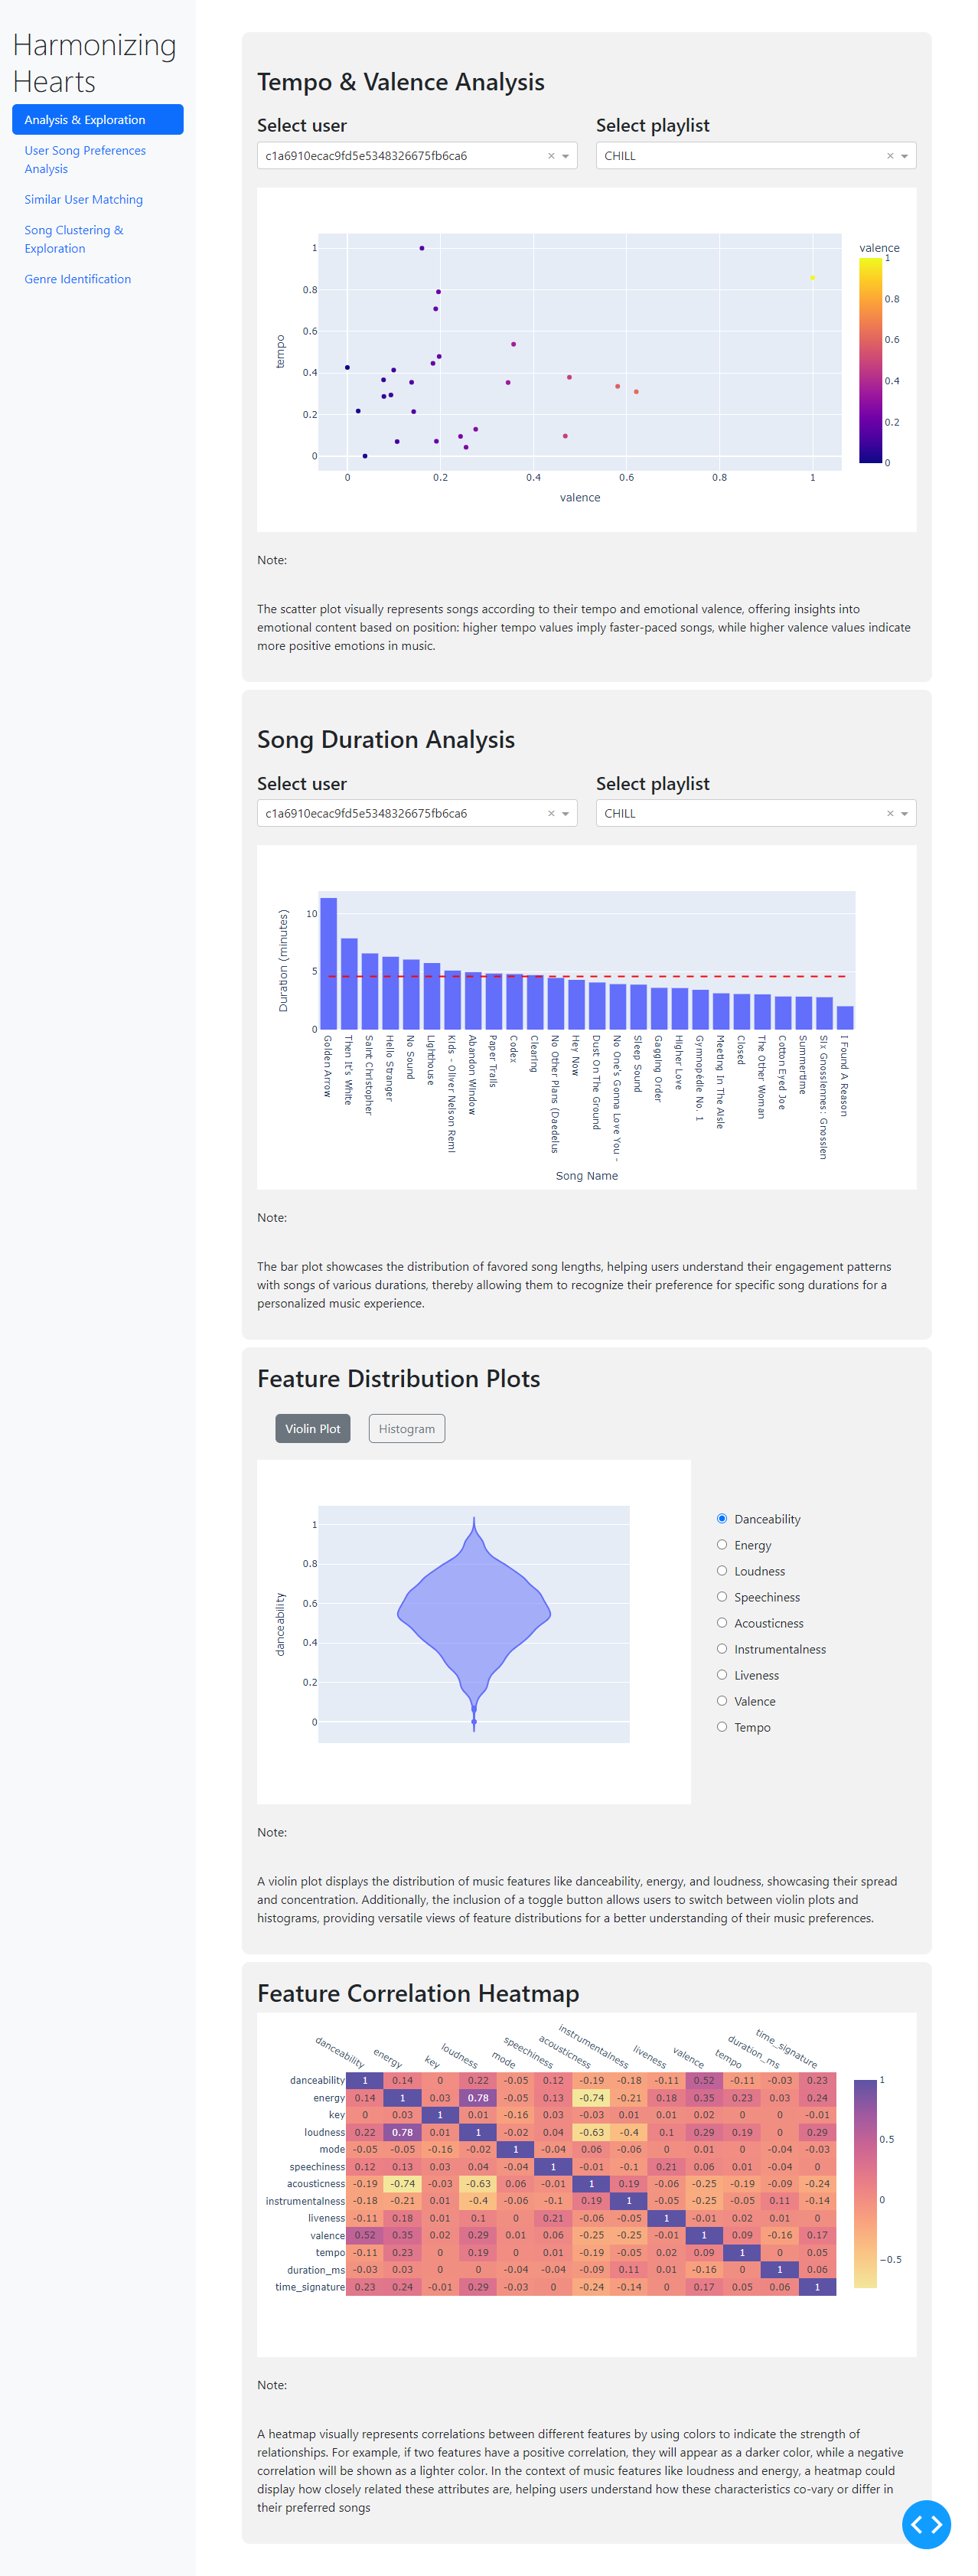

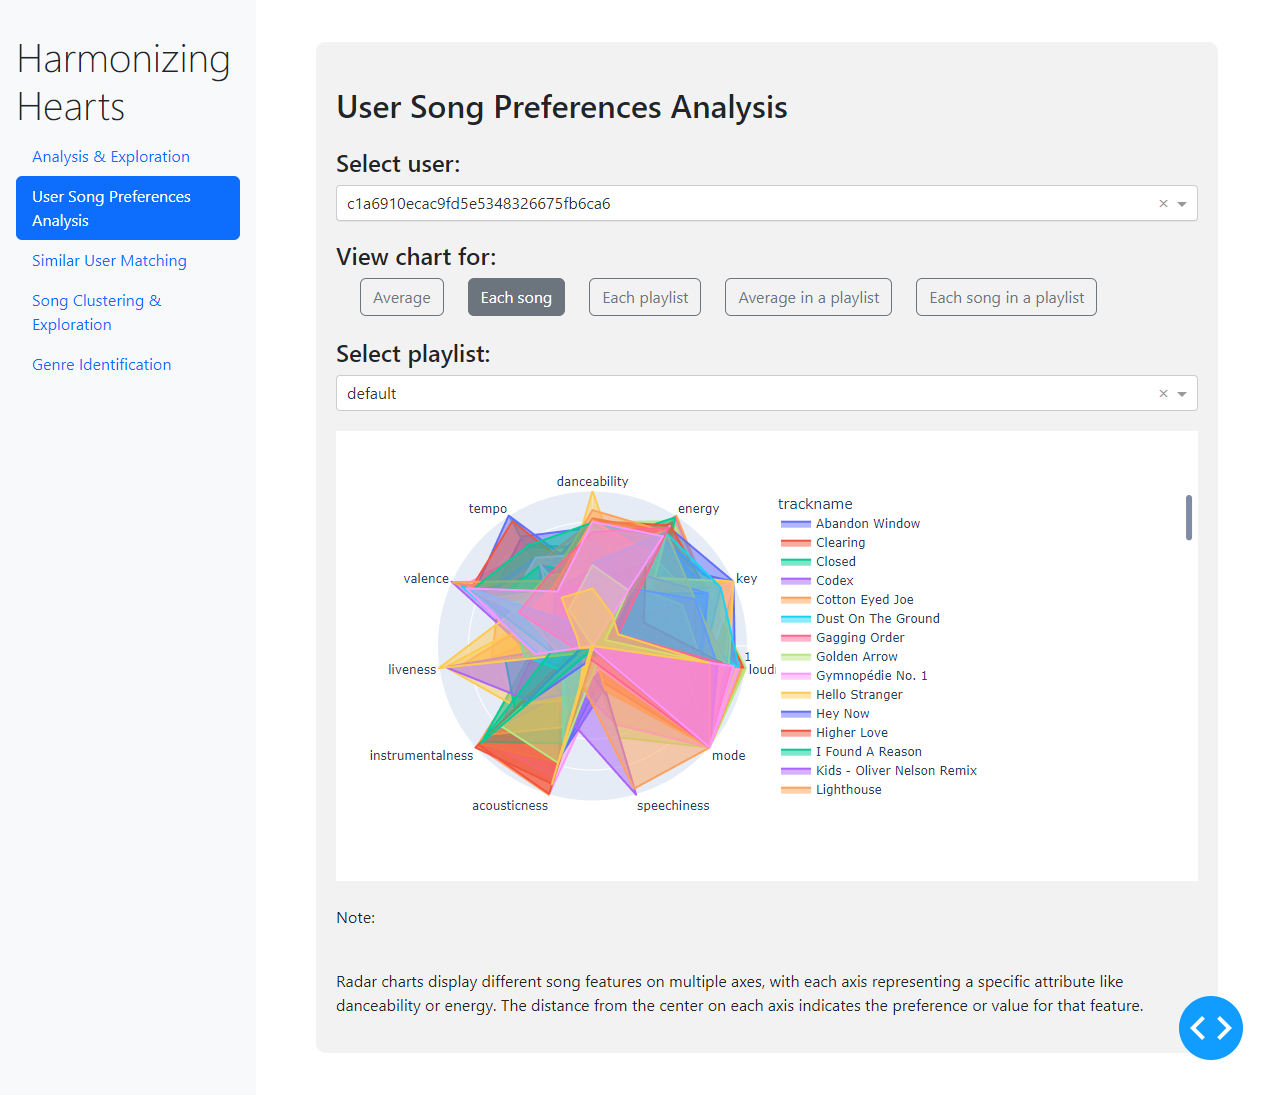

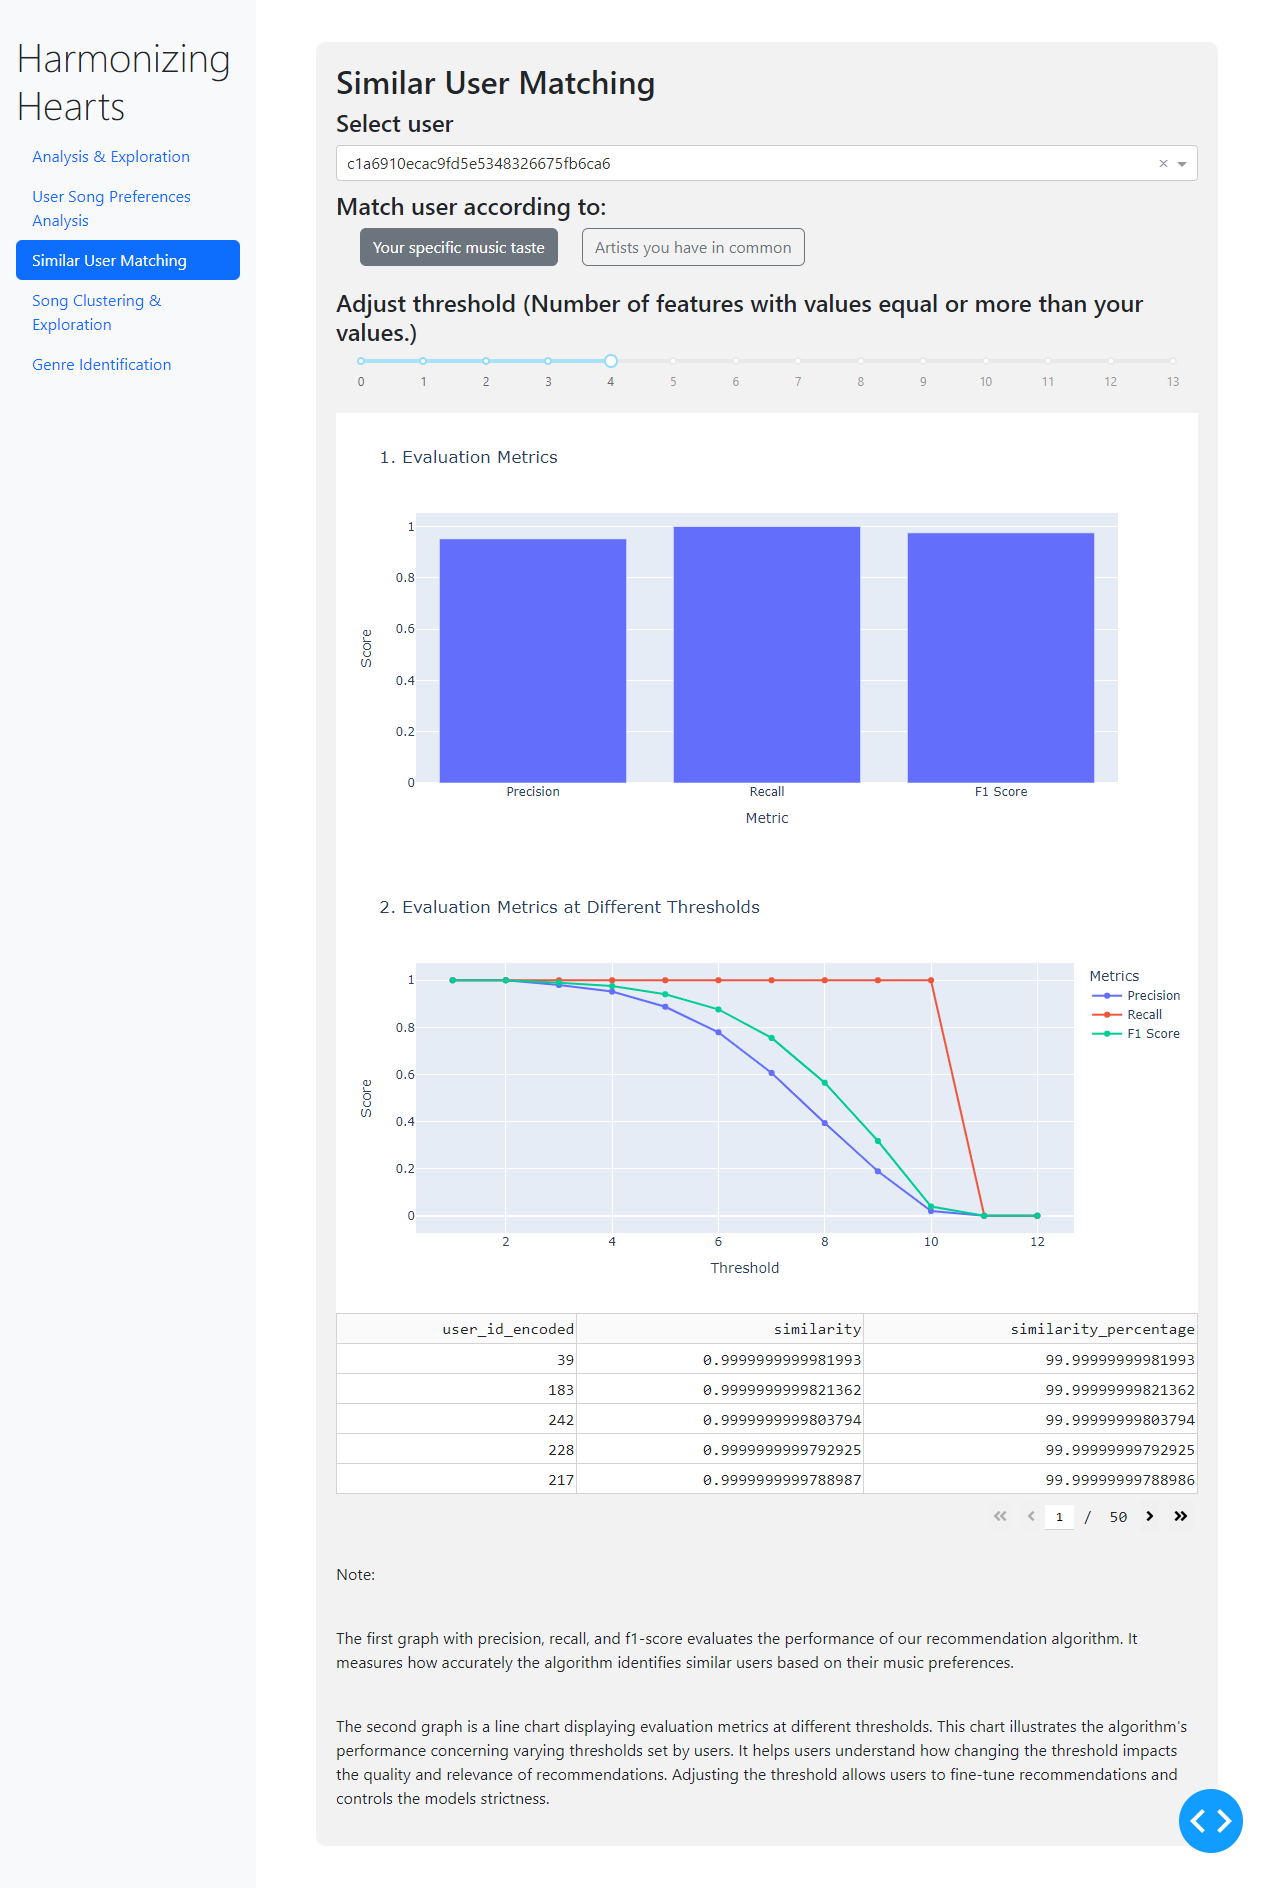

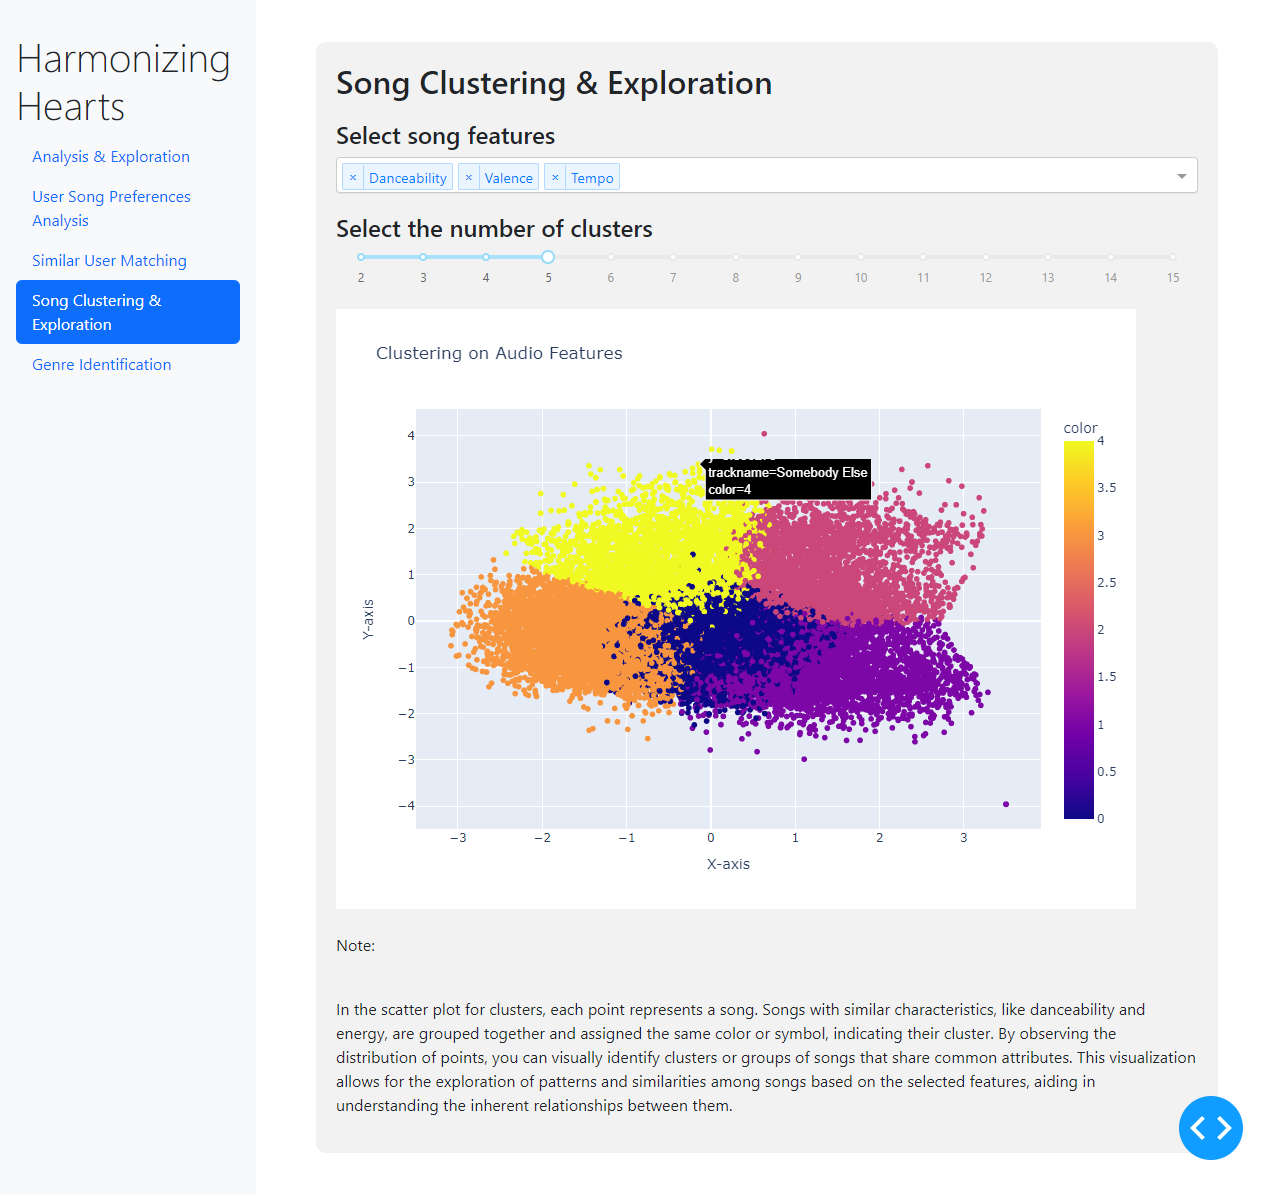

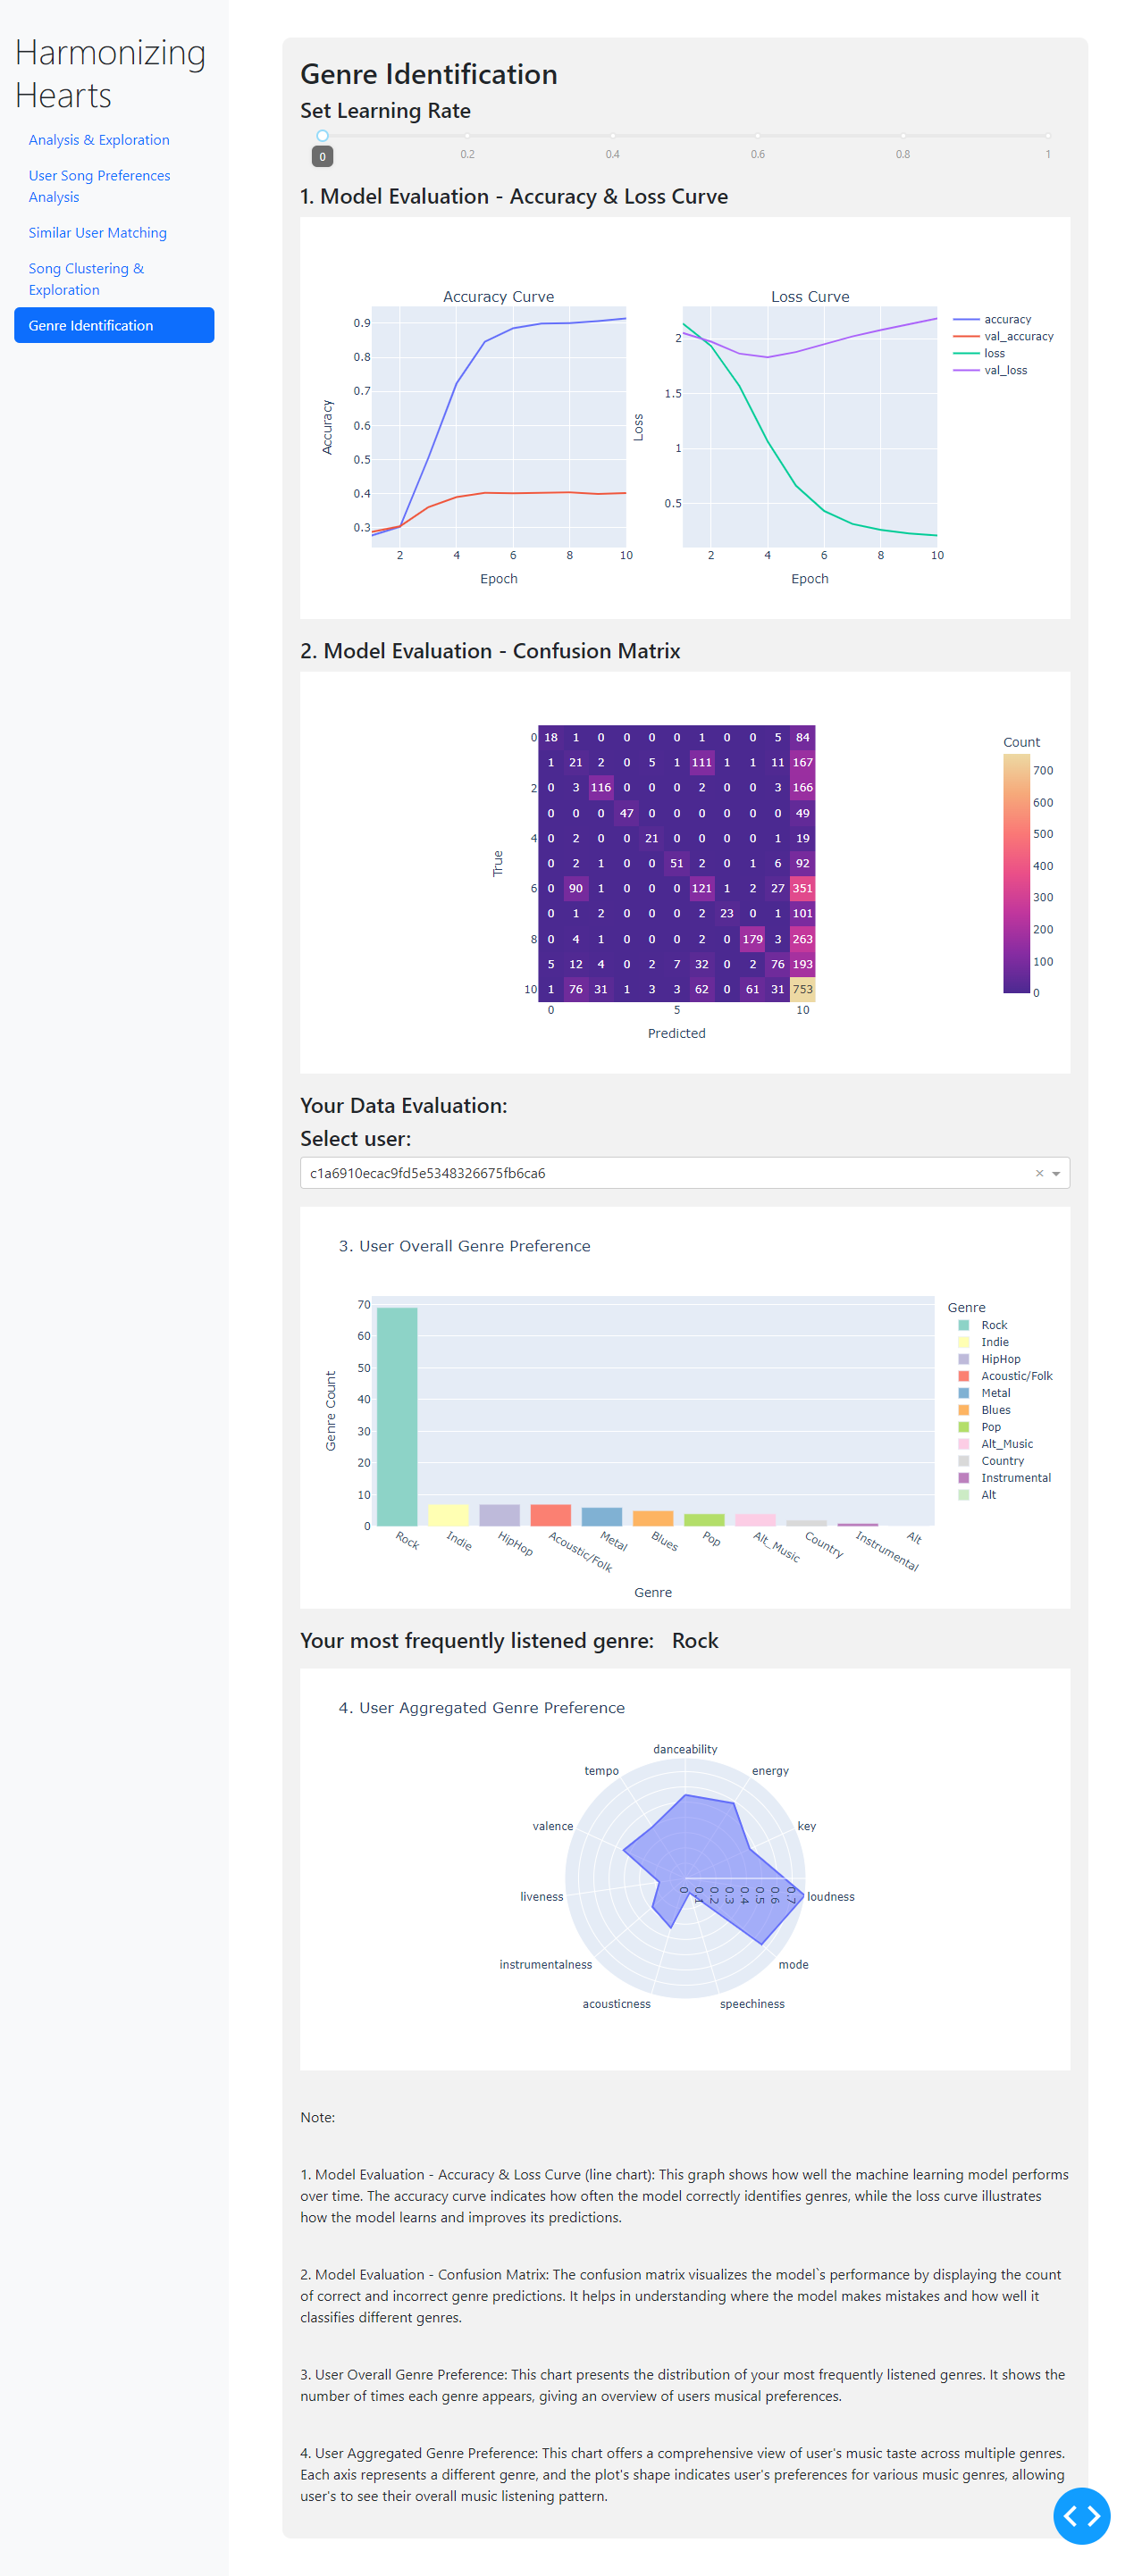

## References :

[1] Acharya, A. (2023). Spotify Dataset [Data set].<br>
[2] Larxel. (2021). Spotify Playlists [Data set].<br>
[3] SongRecommendation-collaborativeFiltering-cluster. (2022, December 14). Kaggle.com. [Online]. Available: https://www.kaggle.com/code/shriyutha/songrecommendation-collaborativefiltering-cluster<br>
[4] Recommendation systems • ranking/scoring. (n.d.). Aman.ai. [Online]. Available: https://aman.ai/recsys/ranking/<br>
[5] Aher, P. (2023, August 9). Evaluation metrics for recommendation systems — an overview. Towards Data Science. [Online]. Available: https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba<br>
[6] Reddit - dive into anything. (n.d.). Reddit.com. [Online]. Available: https://www.reddit.com/r/learnmachinelearning/comments/16notit/collaborative_filtering_jaccard_similarity_vs/<br>
[7] Halilovic, I. (2021, July 30). Markdown for Jupyter notebooks cheatsheet - Inge Halilovic - Medium. Medium. [Online]. Available: https://ingeh.medium.com/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed<br>
[8] Zach. (2023). How to create a distribution plot in Matplotlib. Statology. [Online]. Available: https://www.statology.org/matplotlib-distribution-plot/<br>
[9] Seaborn.Heatmap — seaborn 0.13.0 documentation. (n.d.). Pydata.org. [Online]. Available: https://seaborn.pydata.org/generated/seaborn.heatmap.html<br>
[10] Sharma, P. (2019, August 19). The ultimate guide to K-means clustering: Definition, methods and applications. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/ <br>
[11] Stewart, M. (2019, June 17). Introduction to neural networks. Towards Data Science. https://towardsdatascience.com/simple-introduction-to-neural-networks-ac1d7c3d7a2c <br>
[12] Column transformer with mixed types. (n.d.). Scikit-Learn. Retrieved December 19, 2023, from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html<br>
[13] Plotly: Low-code data app development. (n.d.). Plotly.com. Retrieved December 19, 2023, from https://plotly.com/<br>
[14] Selecting the number of clusters with silhouette analysis on KMeans clustering. (n.d.). Scikit-Learn. Retrieved December 19, 2023, from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html<br>
[15] Sklearn.Preprocessing.OneHotEncoder. (n.d.). Scikit-Learn. Retrieved December 19, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html<br>
[16] Sklearn.decomposition.PCA. (n.d.). Scikit-Learn. Retrieved December 19, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html<br>
[17] TensorFlow. (n.d.). TensorFlow. Retrieved December 19, 2023, from https://www.tensorflow.org/<br>
[18] Dash bootstrap components. (n.d.). Faculty.Ai. Retrieved December 19, 2023, from https://dash-bootstrap-components.opensource.faculty.ai/<br>